In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip /content/drive/MyDrive/lgg-mri-segmentation2.zip

Archive:  /content/drive/MyDrive/lgg-mri-segmentation2.zip
replace lgg-mri-segmentation2/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! pip install patchify

In [3]:
# Import libraries
import os
import cv2
import IPython
import random
import glob
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from patchify import patchify
from keras import layers
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model , load_model
from keras.applications import VGG19
from keras.applications import DenseNet121
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [4]:
# Image config
img_size = 256
num_channels = 3
input_shape = (img_size, img_size, num_channels)

# Transformers encoder hyperparameters config
patch_size = 16
num_patches = (img_size // patch_size) * (img_size // patch_size)
mlp_dim = 3072  # dimensionality of the hidden layers in the Multi-Layer Perceptron (MLP) component of the mode
num_heads = 12  # Number of attention heads in the multi-head attention layer
hidden_dim = 768 # the size of the feature vectors (embeddings) for representing the input data
dropout_rate= 0.2
transformer_layers = 12 # Number of transformer blocks
flat_patches_shape = (num_patches, patch_size*patch_size*num_channels)

In [5]:
# This dataset contains 110 brain MR images together with manual FLAIR abnormality segmentation masks. All images are with 3 channels per image. Masks are binary, 1-channel images.
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
root_folder = './lgg-mri-segmentation2/kaggle_3m/'

In [6]:
# loading dataset
masks = glob.glob(f"{root_folder}*/*_mask*")
diagnosis = [np.any(cv2.imread(file)) for file in masks]
images = [file.replace('_mask', '') for file in masks]
print("Images: ", len(images))
print("Masks: ",len(masks))

Images:  1781
Masks:  1781


In [ ]:
# Sorting check
idx = random.randint(0, len(images)-1)
print("Path to the Image:", images[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: ./lgg-mri-segmentation2/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_33.tif 
Path to the Mask: ./lgg-mri-segmentation2/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_33_mask.tif


In [ ]:
missing_masks = 0
for folder in os.listdir(root_folder):
    folderpath = os.path.join(root_folder, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        if file[:len(file)-4][-1].isnumeric():
            if file[:len(file)-4]+'_mask.tif' not in filelist:
                missing_masks += 1
                print(f"Image without mask: {os.path.join(folderpath, file)}")
print(f"Total number of missing masks: {missing_masks}")

Image without mask: ./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_16.tif
Image without mask: ./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_19.tif
Image without mask: ./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_27.tif
Total number of missing masks: 3


In [ ]:
df = pd.DataFrame({"image_path": images, "mask_path": masks, "diagnosis": diagnosis})
df

,image_path,mask_path,diagnosis
0,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,True
1,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,True
2,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,True
3,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,True
4,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,./lgg-mri-segmentation2/kaggle_3m/TCGA_DU_5854...,True
...,...,...,...
1776,./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_5393...,./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_5393...,True
1777,./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_5393...,./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_5393...,True
1778,./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_5393...,./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_5393...,False
1779,./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_5393...,./lgg-mri-segmentation2/kaggle_3m/TCGA_CS_5393...,False


diagnosis
True     1023
False     758
Name: count, dtype: int64


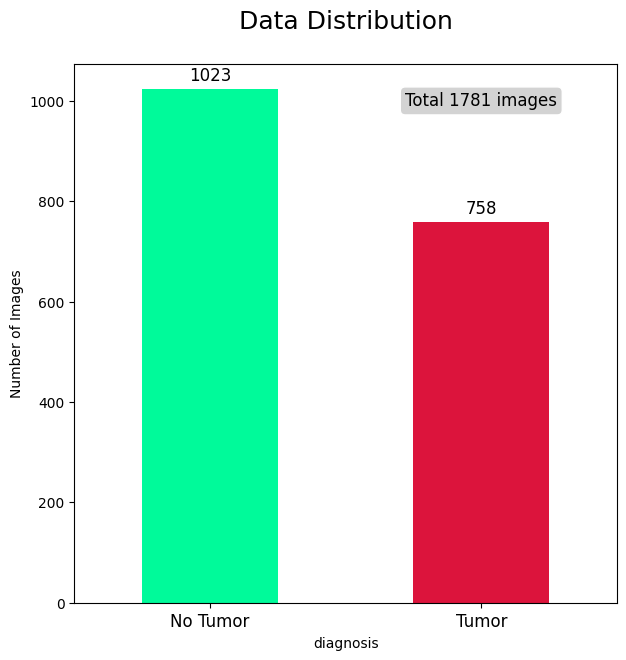

In [ ]:
# Plot
print(df['diagnosis'].value_counts())
ax = df['diagnosis'].value_counts().plot(kind='bar',stacked=True,figsize=(7, 7),color=["mediumspringgreen", "crimson"])
ax.set_xticklabels(["No Tumor", "Tumor"], rotation=0, fontsize=12);
ax.set_ylabel('Number of Images', fontsize = 10)
ax.set_title("Data Distribution",fontsize = 18, y=1.05)

for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+10), rotation=0, color="black", ha="center", verticalalignment='bottom', fontsize=12)

ax.text(1, 1000, f"Total {len(df)} images", size=12, color="black", ha="center", va="center", bbox=dict(boxstyle="round", fc=("lightgray"), ec=("white")));

In [7]:
img_dataset =[]

for image in images:
    #read images in RGB
    image = cv2.imread(image , 1)
    image = cv2.resize(image, (img_size, img_size))
    image = image / 255.0
    img_dataset.append(image)

img_dataset = np.array(img_dataset)
print(img_dataset.shape)
print("Image shape: ", img_dataset[0].shape)


(1781, 256, 256, 3)
Image shape:  (256, 256, 3)


In [8]:
msk_dataset =[]

for mask in masks:
    #read masks in Grayscale
    mask = cv2.imread(mask , cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    mask = np.expand_dims(mask, axis=-1)
    msk_dataset.append(mask)

msk_dataset = np.array(msk_dataset)
print(msk_dataset.shape)
print("Mask shape: ", msk_dataset[0].shape)

(1781, 256, 256, 1)
Mask shape:  (256, 256, 1)


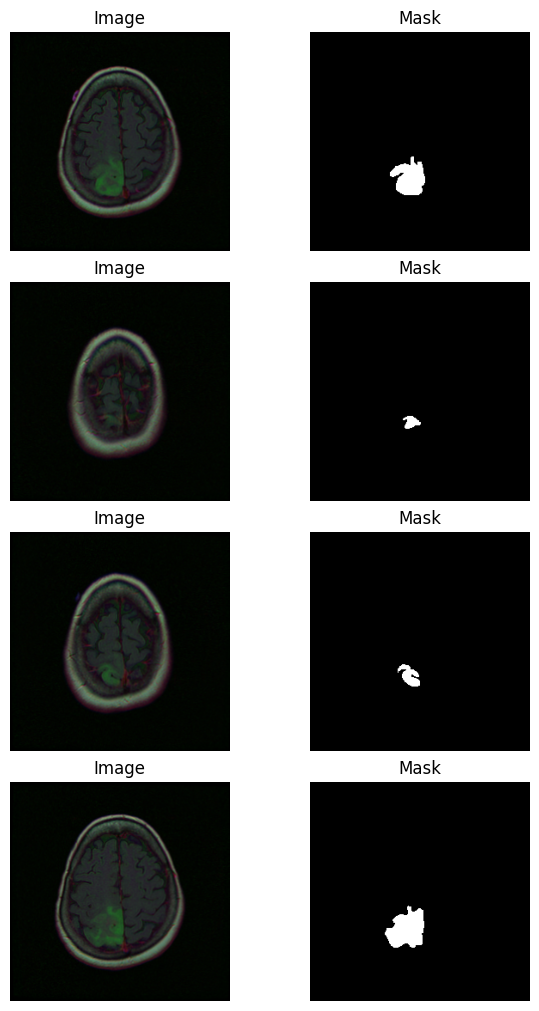

In [9]:
# visualizing data
count = 0
i = 0
fig, axs = plt.subplots(4, 2, figsize=(6, 10), constrained_layout=True)
for mask in msk_dataset:
    # read images
    img = img_dataset[i]
    axs[count][0].imshow(img)
    axs[count][0].set_title('Image', fontdict = {'fontsize':12})
    axs[count][0].axis(False)

    # read masks
    msk = msk_dataset[i]
    axs[count][1].imshow(msk, cmap='gray')
    axs[count][1].set_title('Mask' , fontdict = {'fontsize':12})
    axs[count][1].axis(False)

    count +=1
    i += 1
    if (count==4):
        break

plt.show()

In [ ]:
print("all labels : ", np.unique(msk_dataset))

all labels :  [0. 1.]


In [10]:
# split data into training & testing dataset
X_train, X_test, y_train, y_test = train_test_split(img_dataset, msk_dataset, test_size = 0.20, random_state = 42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1424, 256, 256, 3)
y_train shape:  (1424, 256, 256, 1)
X_test shape:  (357, 256, 256, 3)
y_test shape:  (357, 256, 256, 1)


In [11]:
# cutting up 256X256 images into 16X16 patches for fedding them into the Tranformers encoder
x_train =[]
x_test =[]

for img in X_train:
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)  # (16, 16, 1, 16, 16, 3)
    rs_patches = np.reshape(patches, flat_patches_shape)
    x_train.append(rs_patches)

for img in X_test:
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size) # (16, 16, 1, 16, 16, 3)
    rs_patches = np.reshape(patches, flat_patches_shape)
    x_test.append(rs_patches)

x_train = np.array(x_train)
x_test = np.array(x_test)
print('Transformers x_train shape: ', x_train.shape)
print('Transformers x_test shape: ', x_test.shape)

Transformers x_train shape:  (1424, 256, 768)
Transformers x_test shape:  (357, 256, 768)


### UNETR 2D

In [14]:
# UNETR model => Transformer ecoder (as backbone to leran the global contexual representation) & CNN-based decoder (to upsample the global representation and generate the final segmentation mask)
# encoder
def mlp(x, mlp_dim, hidden_dim, dropout_rate):
    x = layers.Dense(mlp_dim, activation="gelu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def vit_encoder(x, num_heads, hidden_dim):
    # Layer normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-7)(x)
    # multi-head attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=0.1)(x1, x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, x])
    # Layer normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-7)(x2)
    # MLP
    x3 = mlp(x3, mlp_dim, hidden_dim, dropout_rate)
    x = layers.Add()([x3, x2])
    return x

# decoder
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def deconv_block(x, num_filters):
    x = layers.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [15]:
def UNETR_2D():
    input_shape = (num_patches, patch_size*patch_size*num_channels)
    inputs = layers.Input(input_shape)

    # Patch & Position Embeddings ----------------------------------------------------------------------
    patch_embed = layers.Dense(hidden_dim)(inputs)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positions_embed = layers.Embedding(input_dim=num_patches, output_dim=hidden_dim)(positions)
    x = patch_embed + positions_embed

    # Transformer Encoder ------------------------------------------------------------------------------
    skip_connection_index = [3, 6, 9, 12] # the number of transformers layers in which there are skip conncetions based on the original paper (z3, z6,z9,z12)
    skip_connections = [] # svae the outputs of transformers layers in which there are skip conncetions

    # 12 layers of the Transformer block
    for i in range(1, transformer_layers+1, 1):
        x = vit_encoder(x, num_heads, hidden_dim)
        if i in skip_connection_index:
            skip_connections.append(x)

    # CNN Decoder ---------------------------------------------------------------------------------------
    z3, z6, z9, z12 = skip_connections

    # reshape the transformers outputs to pass to the CNN decoder (skip connections)
    z0 = layers.Reshape((img_size, img_size, num_channels))(inputs)
    shape = (img_size//patch_size,img_size//patch_size,hidden_dim)
    z3 = layers.Reshape(shape)(z3)
    z6 = layers.Reshape(shape)(z6)
    z9 = layers.Reshape(shape)(z9)
    z12 = layers.Reshape(shape)(z12)

    ## Decoder 1--------------
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2--------------
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3--------------
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4--------------
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    outputs = layers.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [16]:
UNETR_model = UNETR_2D()
UNETR_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 768)]           0         []                            
                                                                                                  
 dense (Dense)               (None, 256, 768)             590592    ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 768)             0         ['dense[0][0]']               
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 256, 768)             1536      ['tf.__operators__.add[0][

In [ ]:
keras.utils.plot_model(
    UNETR_model,
    to_file='./img/UNETR_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
UNETR_model.compile(optimizer=Adam(lr=0.0001), loss = "binary_crossentropy" , metrics = ['accuracy'])

UNETR_checkpoint = ModelCheckpoint("./drive/MyDrive/Colab Notebooks/Brain_UNETR.weights.h5",monitor='val_loss', verbose=1, save_best_only=True, mode='max')
UNETR_early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
UNETR_reduce_learningrate = ReduceLROnPlateau(monitor='val_acc',factor=0.2, patience=10, verbose=1, min_lr = 2e-6)
UNETR_callbacks_list = [UNETR_early_stopping,UNETR_checkpoint,UNETR_reduce_learningrate]

In [22]:
history_UNETR = UNETR_model.fit(x_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(x_test, y_test), callbacks = UNETR_callbacks_list, shuffle=True)

Epoch 1/30
89/89 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9825
Epoch 1: val_loss improved from -inf to 0.09317, saving model to ./drive/MyDrive/Colab Notebooks/Brain_UNETR.weights.h5


89/89 [==============================] - 139s 1s/step - loss: 0.0773 - accuracy: 0.9825 - val_loss: 0.0932 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 2/30
89/89 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9825
Epoch 2: val_loss did not improve from 0.09317


89/89 [==============================] - 80s 903ms/step - loss: 0.0686 - accuracy: 0.9825 - val_loss: 0.0824 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 3/30
89/89 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9825
Epoch 3: val_loss improved from 0.09317 to 0.11121, saving model to ./drive/MyDrive/Colab Notebooks/Brain_UNETR.weights.h5


89/89 [==============================] - 96s 1s/step - loss: 0.0598 - accuracy: 0.9825 - val_loss: 0.1112 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 4/30
89/89 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9827
Epoch 4: val_loss did not improve from 0.11121


89/89 [==============================] - 80s 903ms/step - loss: 0.0552 - accuracy: 0.9827 - val_loss: 0.0682 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 5/30
89/89 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9844
Epoch 5: val_loss did not improve from 0.11121


89/89 [==============================] - 80s 903ms/step - loss: 0.0504 - accuracy: 0.9844 - val_loss: 0.0464 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 6/30
89/89 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9863
Epoch 6: val_loss did not improve from 0.11121


89/89 [==============================] - 80s 894ms/step - loss: 0.0437 - accuracy: 0.9863 - val_loss: 0.0526 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 7/30
89/89 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9853
Epoch 7: val_loss did not improve from 0.11121


89/89 [==============================] - 80s 894ms/step - loss: 0.0494 - accuracy: 0.9853 - val_loss: 0.0532 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 8/30
89/89 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9837
Epoch 8: val_loss did not improve from 0.11121


89/89 [==============================] - 80s 895ms/step - loss: 0.0567 - accuracy: 0.9837 - val_loss: 0.0570 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 9/30
89/89 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9853
Epoch 9: val_loss did not improve from 0.11121


89/89 [==============================] - 80s 895ms/step - loss: 0.0493 - accuracy: 0.9853 - val_loss: 0.0785 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 10/30
89/89 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9862
Epoch 10: val_loss did not improve from 0.11121


89/89 [==============================] - 80s 903ms/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.0462 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 11/30
33/89 [==========>...................] - ETA: 46s - loss: 0.0433 - accuracy: 0.9867

KeyboardInterrupt: 

In [ ]:
# evalute model
loss_UNETR,acc_UNETR= UNETR_model.evaluate(x_test, y_test, verbose=1)
print("accuracy:", acc_UNETR)

9/9 [==============================] - 11s 488ms/step - loss: 0.7475 - accuracy: 0.7210
accuracy: 0.7209751009941101


In [24]:
Brain_tumor_model_UNETR = load_model('./drive/MyDrive/Colab Notebooks/Brain_UNETR.weights.h5', compile=True, safe_mode=True)

In [25]:
loss_UNETR2,acc_UNETR2= Brain_tumor_model_UNETR.evaluate(x_test, y_test, verbose=1)
print("accuracy:", acc_UNETR2)

12/12 [==============================] - 14s 485ms/step - loss: 0.1112 - accuracy: 0.9834
accuracy: 0.9833589196205139


In [26]:
y_pred_UNETR=Brain_tumor_model_UNETR.predict(x_test)

12/12 [==============================] - 8s 482ms/step


In [27]:
y_pred_UNETR_argmax=np.argmax(y_pred_UNETR, axis=3)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'layer_normalization' (type LayerNormalization).
    
    Cannot take the length of shape with unknown rank.
    
    Call arguments received by layer 'layer_normalization' (type LayerNormalization):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)


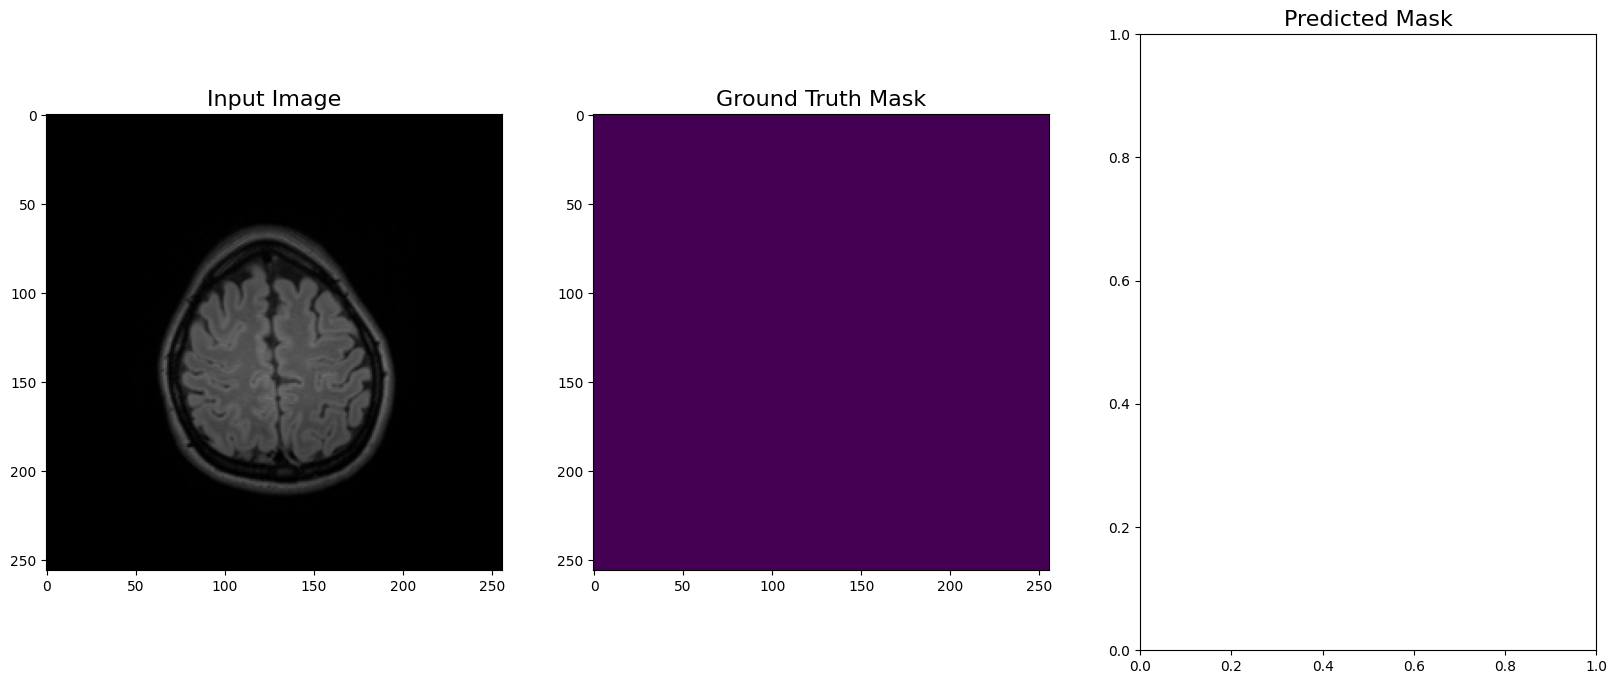

In [34]:
for i in range(10):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test[i])

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(Brain_tumor_model_UNETR.predict(x_test[i]))

    plt.show()